In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, SimpleRNN
from tensorflow.keras.models import Model

In [2]:
dataset = pd.read_csv('song_data.csv')
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

n_users = len(dataset.user_id.unique())#사용자 수 총 몇명?
n_songs = len(dataset.song_id.unique()) # 노래 총 몇개?

## Rating? 모르겟는
## 가사는 Word2Vec 혹은 TF-IDF 벡터 기술 사용해 텍스트 가사의 임베딩 얻을수 있음

In [3]:
dataset.head()

,song_id,user_id,rating
0,1,314.0,5.0
1,1,439.0,3.0
2,1,588.0,5.0
3,1,1169.0,4.0
4,1,1185.0,4.0


## 위 dataset은 text가 없으므로 두 기반항목으로 노래 추천하는 방법 보여줌

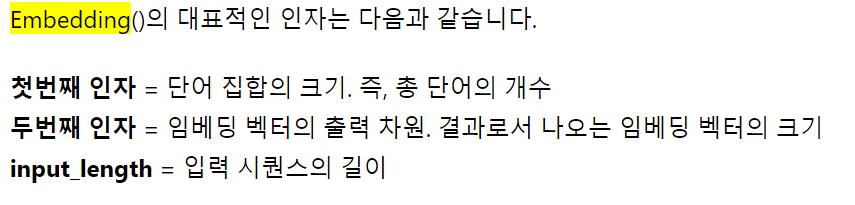

### 아래 그림과 같이 Dense Layer에서는 3차원의 웟핫벡터에서 5차원으로 증가시키고 싶을경우 5번의 연산 수행필요함

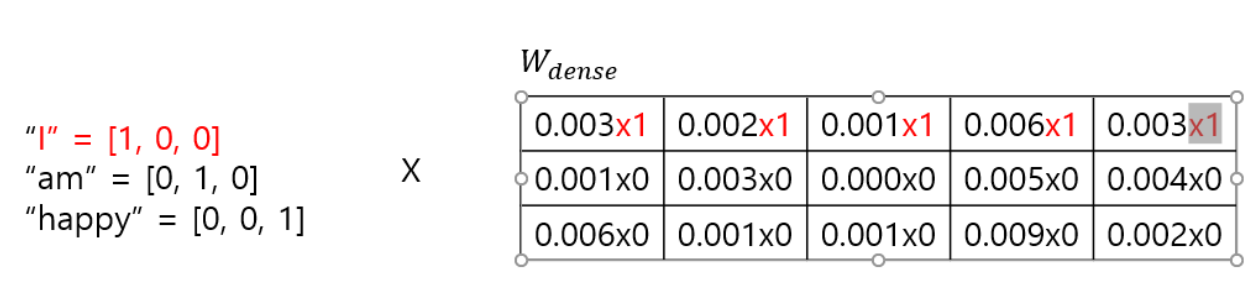

### 하지만 아래 embedding layer에서는 가중치 matrix 0행만 가져오는 것을 수행함으로 빠른 성능

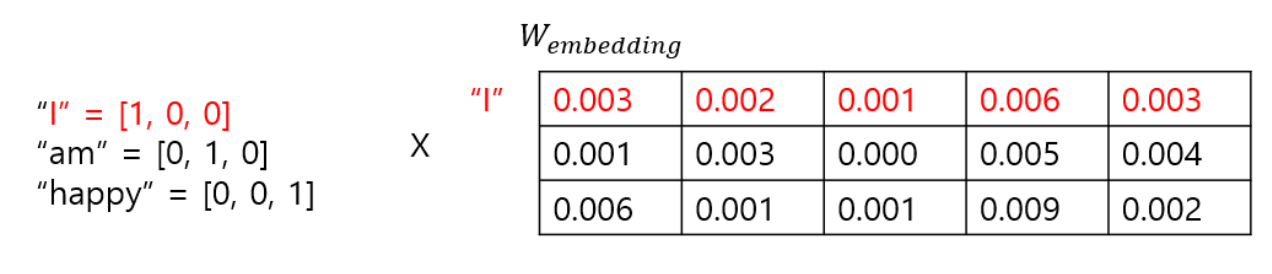

즉 아래 코드의 Embedding layer는 입력값의 총개수 (unique)값+1에 5차원으로 ouput값이 나오는 형태로 Embedding layer를 생성하였다.

Model(inputs=[], ouputs=[])

In [4]:
song_input = Input(shape=[1], name="Song-Input") # 노래 id input


song_embedding = Embedding(n_songs+1, 5, name="Song-Embedding")(song_input)
##? 그럼 왜 embedding?
## 총 노래가 n개 가 있다면 n개중에 입력으로 어떤 vector의 feature인지 알고
## 그 확률값을 제일 높은 것을 고르기 위해 입력값으로 사용 , output이 5인것은 rank값이 5개밖에 없기 때문이다.
song_vec = Flatten(name="Flatten-Songs")(song_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
# +1은 embedding은 0부터시작하기때문에?
user_embedding1 = SimpleRNN(20, name="User-Embedding1")(user_embedding)
##? simple RNN을 추가하는 이유는 뭘까요?

user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([song_vec, user_vec])
model = Model([user_input, song_input], prod)
model.compile('adam', 'mean_squared_error')

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Song-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Song-Embedding (Embedding)     (None, 1, 5)         23285       ['Song-Input[0][0]']             
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         149110      ['User-Input[0][0]']             
                                                                                              

In [5]:
history = model.fit([train.user_id, train.song_id], train.rating, epochs=10, verbose=1)

Epoch 1/10
11617/11617 [==============================] - 49s 4ms/step - loss: 15.2394
Epoch 2/10
11617/11617 [==============================] - 42s 4ms/step - loss: 11.1373
Epoch 3/10
11617/11617 [==============================] - 42s 4ms/step - loss: 8.3494
Epoch 4/10
11617/11617 [==============================] - 43s 4ms/step - loss: 7.4811
Epoch 5/10
11617/11617 [==============================] - 42s 4ms/step - loss: 7.1702
Epoch 6/10
11617/11617 [==============================] - 42s 4ms/step - loss: 7.0184
Epoch 7/10
11617/11617 [==============================] - 42s 4ms/step - loss: 6.9287
Epoch 8/10
11617/11617 [==============================] - 42s 4ms/step - loss: 6.8686
Epoch 9/10
11617/11617 [==============================] - 42s 4ms/step - loss: 6.8264
Epoch 10/10
11617/11617 [==============================] - 42s 4ms/step - loss: 6.7945


In [6]:
# Extract embeddings
song_em = model.get_layer('Song-Embedding')
song_em_weights = song_em.get_weights()[0]

## song Embedding 이 어떻게 보이는지 PCA로 차원축소

<Axes: >

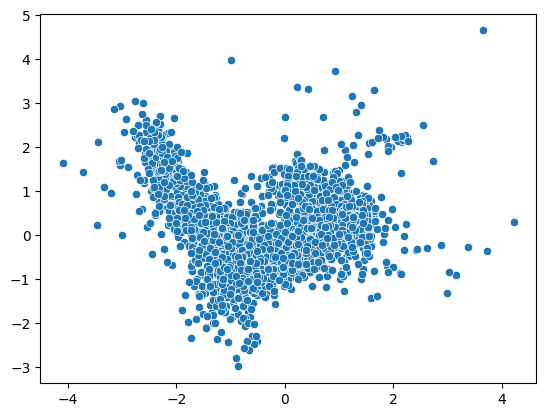

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(song_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [16]:
song_data = np.array(list(set(dataset.song_id)))
user = np.array([1 for i in range(len(song_data))])
user,song_data

(array([1, 1, 1, ..., 1, 1, 1]),
 array([   1,    2,    3, ..., 4654, 4655, 4656]))

In [ ]:
predictions = model.predict([user, song_data]) # userid 1과 전체 song id 집어넣기
predictions = np.array([a[0] for a in predictions]) # rating에 대한 점수 예측값 np.array로
print(predictions)
recommended_song_ids = (-predictions).argsort()[:5] # sort된것중 가장 높은것 index순 으로 반환

In [18]:
print(recommended_song_ids) # 추천된 index
print(predictions[recommended_song_ids])  # rating의 높은순 5개

[3478 2655 2032 3092 2584]
[0.13071361 0.12090896 0.11136865 0.11011891 0.10671727]


사용자 4가 좋아하는 노래를 사용자 0과 1이 좋아할 확률

협업 필터링으로 각 노래를 id에 따라 좋아할 확률을 전체적으로 계산한것?
